In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

In [2]:
root_dir = r"/Users/tharhtet/Documents/github/Practical-ML-by-WAI/6_deep_learning/CNN/cats_and_dogs_filtered"

In [3]:
BATCH_SIZE  = 32
EPOCHS = 20
input_img_size = (128,128)
input_shape = (128,128,3)
dropout_rate = 0.6

In [4]:
# Data Augmentation
tf_generator =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_ds = tf_generator.flow_from_directory(
    root_dir+"/train",
    target_size=input_img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical' #binary
)
val_ds = tf_generator.flow_from_directory(
    root_dir+"/test",
    target_size=input_img_size,
    batch_size=BATCH_SIZE,
    class_mode= 'categorical' #binary
)

Found 2752 images belonging to 2 classes.
Found 248 images belonging to 2 classes.


In [5]:
# 1. Load a pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)


2025-08-22 15:22:29.214762: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-08-22 15:22:29.214785: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-08-22 15:22:29.214789: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1755850949.214802 42901544 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1755850949.214817 42901544 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# 2. Freeze the convolutional base
base_model.trainable = False

In [7]:
# 3. Add new classification layers

x = base_model.output
x = GlobalAveragePooling2D()(x) # Averages the spatial locations, reducing parameters
x = Dense(128, activation='relu')(x)
x = Dropout(dropout_rate)(x) 
predictions = Dense(2, activation='softmax')(x)

In [8]:
# 4. Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # A slightly lower initial LR is good practice
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
history = model.fit(train_ds,epochs=EPOCHS, validation_data=val_ds,verbose=1)

Epoch 1/20


/opt/anaconda3/envs/ths_dev/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-08-22 15:22:29.928606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.5777 - loss: 0.8560 - val_accuracy: 0.7782 - val_loss: 0.4800
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7027 - loss: 0.6030 - val_accuracy: 0.7944 - val_loss: 0.4293
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7751 - loss: 0.4920 - val_accuracy: 0.8347 - val_loss: 0.4209
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7712 - loss: 0.4760 - val_accuracy: 0.8306 - val_loss: 0.4142
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8094 - loss: 0.4240 - val_accuracy: 0.8145 - val_loss: 0.4237
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8048 - loss: 0.4268 - val_accuracy: 0.8226 - val_loss: 0.4044
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8171 - loss: 0.3986 - val_accuracy: 0.8629 - val_loss: 0.3560
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8157 - loss: 0.3988 - val_accuracy: 0.8427 - val_loss: 0.

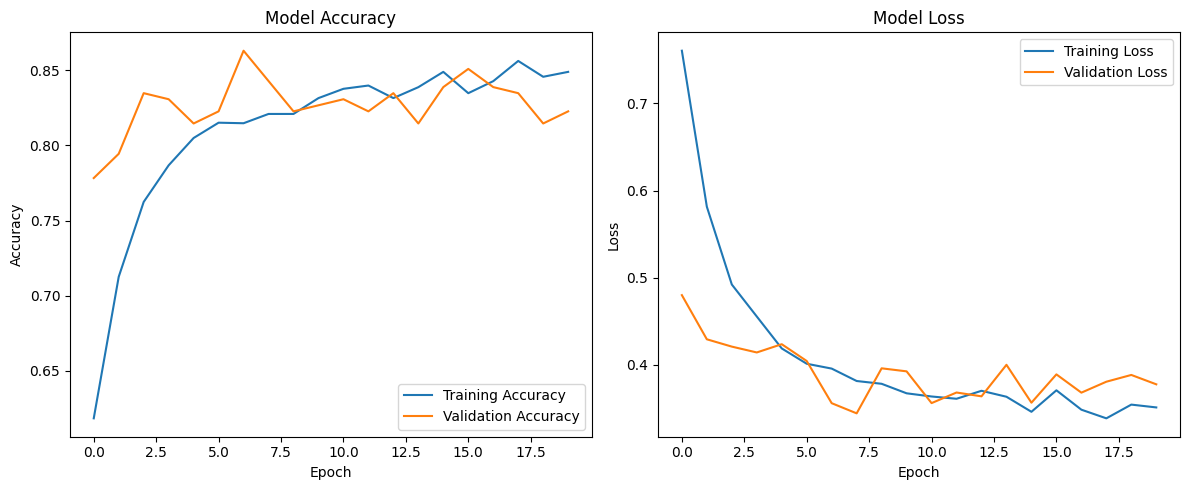

In [11]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()